<h2>SVD and Collaborative Filtering Based Movie Recomendation System on MovieLens 100K Dataset</h2>

<p>To implement our recommendation system we built a user factorization matrix as popularized by Netflix and calculated SVD through sci-kit and compared the resulting Root Mean Square Error against a collaborative filter model</p>

<h3>Imports</h3>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import sys
import pickle
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split

sns.set_style("dark")
plt.rcParams['patch.force_edgecolor'] = True

In [2]:
# Load data
movies = pd.read_csv('Data/movies.csv')
tags = pd.read_csv('Data/tags.csv')
ratings = pd.read_csv('Data/ratings.csv')

<h3>Data Visualization</h3>

Text(0, 0.5, 'Number of Movies')

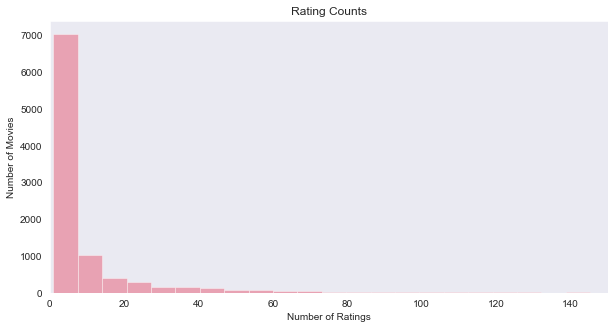

In [3]:
# preprocess for visualization

movie_data = pd.merge(ratings, movies, on='movieId')
movie_data.groupby('title')['rating'].count().sort_values(ascending=False)
ratings_mean_count = pd.DataFrame(movie_data.groupby('title')['rating'].mean())
ratings_mean_count['rating_counts'] = pd.DataFrame(movie_data.groupby('title')['rating'].count())
fig, ax = plt.subplots(figsize=(10,5)) 

counts = ratings_mean_count['rating_counts']

# plotting

sns.distplot(counts, kde=False, color="#e63756", ax=ax)
ax.grid(False)
ax.set_xlim(xmin=0, xmax=150)
ax.set_title("Rating Counts")
ax.set_xlabel("Number of Ratings")
ax.set_ylabel("Number of Movies")

Text(29.0, 0.5, 'Rating')

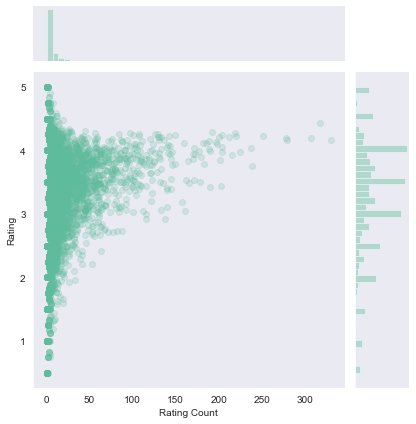

In [4]:
# plotting 
joint_plot = sns.jointplot(x='rating_counts',
                           y='rating',
                           data=ratings_mean_count,
                           alpha=0.2,
                           color="#5ebb9c"
                          )
joint_plot.ax_joint.set_xlabel("Rating Count")
joint_plot.ax_joint.set_ylabel("Rating")

<p>From the first visualization we find that most movies have little to no ratings. Looking at the second visualization we find that the more ratings a movie has the higher the rating is. Evidently, movies which we find "interesting" will be ones
that have many ratings, over 50 to be exact, and these movies will typically be of higher rating.</p>

### Filtering and Cleaning Data

In [5]:
movies['genres'] = movies['genres'].str.replace('|',' ')

print("We have {} unique movies in movies dataset.".format(len(movies.movieId.unique())))

We have 9742 unique movies in movies dataset.


In [6]:
print("We have {} unique movies ratings dataset.".format(len(ratings.movieId.unique())))

We have 9724 unique movies ratings dataset.


In [7]:
# Only select users who have rated more that 50 movies
# Required to distinguish users in a collaborative filtering system

ratings_filtered = ratings.groupby('userId').filter(lambda x: len(x) >= 50)

# list the movie titles that survive the filtering 
filtered_movie_ids = ratings_filtered.movieId.unique().tolist()

Text(0, 0.5, 'Count of Frequency')

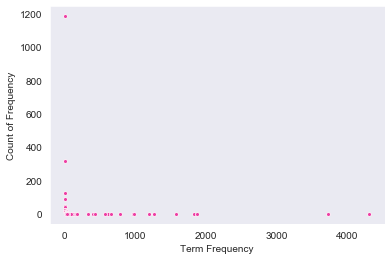

In [8]:
# Filter movie data to only keep the filtered movies
movies_filtered = movies[movies.movieId.isin(filtered_movie_ids)]

# Create a dictionary mapping movie names to id's
name_id_map = dict(zip(movies_filtered.title.tolist(), movies_filtered.movieId.tolist()))

# Drop timestamp data 
# Create a mixed dataframe of movies title, genres 
# All user tags given to each movie

mixed = pd.merge(movies_filtered, tags, on='movieId', how='left')

# create metadata from tags and genres
mixed.fillna("", inplace=True)
mixed = pd.DataFrame(mixed.groupby('movieId')['tag'].apply(lambda x: "%s" % ' '.join(x)))


Final = pd.merge(movies_filtered, mixed, on='movieId', how='left')
Final['metadata'] = Final[['tag', 'genres']].apply(lambda x: ' '.join(x), axis = 1)


# visualizing our metadata column

meta_data = {}
for data in Final['metadata'].values:
    all_data = data.split(" ")
    for entry in all_data:
        if entry != '':
            if entry not in meta_data.keys():
                meta_data[entry] = 1
            else:
                meta_data[entry] += 1
                
# we now get all unique count values and how many times they have occurred
tag_occurrence = {}
for val in meta_data.values():
    if val not in tag_occurrence.keys():
        tag_occurrence[val] = 1
    else:
        tag_occurrence[val] += 1


sorted_tags = sorted(tag_occurrence.items(), key=lambda x: x[1], reverse=True)
scatter = sns.scatterplot(*zip(*sorted_tags), s=15, color="#ed3ea4")
scatter.set_xlabel("Term Frequency")
scatter.set_ylabel("Count of Frequency")

<h3>Create Movie-User Matrix</h3>

In [9]:
ratings_right_filtered = pd.merge(
                                  movies[['movieId']],
                                  ratings_filtered,
                                  on="movieId",
                                  how="right"
                                 )

ratings_pivoted = ratings_right_filtered.pivot(
                                               index='movieId',
                                               columns ='userId',
                                               values = 'rating'
                                              ).fillna(0)

<h3>Collaborative Latent Based</h3>

In [10]:
# is the number of components we select from matrix sigma
# number of components for collaborative filtering
coll_comp = 200 

svd = TruncatedSVD(n_components=coll_comp) 
latent_matrix = svd.fit_transform(ratings_pivoted)
latent_matrix_df = pd.DataFrame(latent_matrix,index=Final.title.tolist())


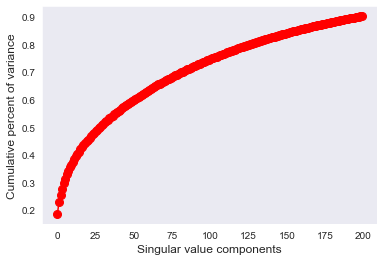

In [11]:
# plot variance expalined to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained,
         '.-',
         ms = 16,
         color='red'
        )
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

<h3>Content (Metadata) Latent Based</h3>

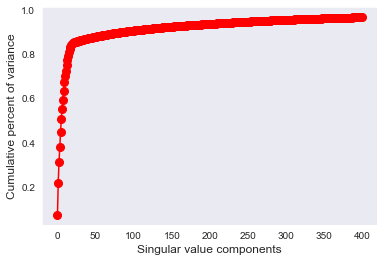

In [12]:
# number of components for content based method
cont_comp = 400

tfidf_vectors = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectors.fit_transform(Final['metadata'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=Final.index.tolist())


# Compress with SVD
svd = TruncatedSVD(n_components=cont_comp)
latent_matrix_content = svd.fit_transform(tfidf_df)

# plot var expalined to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained,
         '.-',
         ms = 16,
         color='red'
        )
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

In [13]:
latent_matrix_content_df = pd.DataFrame(latent_matrix_content[:,0:cont_comp], index=Final.title.tolist())
latent_matrix_content_df

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
Toy Story (1995),0.102533,0.082476,0.069582,0.088458,-0.153009,0.011932,0.234247,-0.009963,-0.125975,-0.008711,...,0.006036,0.007405,-0.007495,0.000211,-0.000139,-0.004768,0.007529,0.007916,0.000141,0.003319
Jumanji (1995),0.032662,0.008606,0.059263,0.089857,-0.107717,0.007152,0.189329,-0.006471,-0.079107,0.001554,...,-0.056438,0.051775,0.039168,-0.009476,0.017630,-0.028872,-0.078074,0.045888,-0.000889,0.014293
Grumpier Old Men (1995),0.148103,0.105284,-0.042406,0.123656,0.096379,-0.039215,-0.011899,0.000625,0.004796,-0.002096,...,-0.063054,0.049353,-0.061612,-0.093264,0.048613,-0.025980,-0.013719,-0.000682,0.013666,-0.059206
Waiting to Exhale (1995),0.824794,0.064959,-0.292050,0.382681,0.267588,-0.079997,-0.045788,-0.000784,0.028433,-0.000409,...,-0.000207,-0.000016,0.000111,0.000019,-0.000003,-0.000013,0.000137,0.000060,-0.000031,0.000208
Father of the Bride Part II (1995),0.113246,0.120812,-0.006388,-0.037367,-0.006870,0.010385,-0.009212,-0.002238,0.004315,-0.011441,...,-0.000551,-0.002405,-0.001974,0.002289,-0.003342,-0.000712,0.001030,-0.002454,-0.000638,-0.001645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Black Butler: Book of the Atlantic (2017),0.330189,0.220857,0.299672,0.151347,-0.331129,-0.097717,0.314852,-0.012915,0.039545,0.078582,...,0.000157,0.000040,0.000077,0.000167,-0.000163,-0.000247,0.000193,-0.000092,0.000100,-0.000059
No Game No Life: Zero (2017),0.297211,0.274882,0.097861,0.106696,-0.228910,0.058769,0.398342,-0.019094,-0.246116,0.014019,...,0.000176,-0.000112,0.000076,0.000142,-0.000199,-0.000238,0.000081,-0.000223,0.000213,-0.000162
Flint (2017),0.632247,-0.667404,-0.300979,-0.126561,-0.164319,0.128696,-0.007100,-0.006457,0.024256,0.015148,...,-0.000012,0.000002,0.000041,0.000064,0.000091,-0.000012,-0.000040,0.000111,-0.000067,0.000033
Bungo Stray Dogs: Dead Apple (2018),0.113959,-0.012874,0.338328,0.166791,-0.311143,-0.184335,0.176230,-0.003624,0.139817,0.098710,...,0.000067,0.000091,-0.000061,0.000066,-0.000084,-0.000198,0.000233,0.000129,-0.000004,-0.000050


###  Recommendation by Cosine Similarity on Latent Content and Collaborative Matrices

In [14]:
def recommend_movie(movie):
    # Take the latent vectors for a selected movie from both content and collaborative matrixes
    a_1 = np.array(latent_matrix_df.loc[movie]).reshape(1, -1)
    a_2 = np.array(latent_matrix_content_df.loc[movie]).reshape(1, -1)

    # Calculate the similartity of this movie with the others in the list
    score_1 = cosine_similarity(latent_matrix_df, a_1).reshape(-1)
    score_2 = cosine_similarity(latent_matrix_content_df, a_2).reshape(-1)
    
    
    
    # an average measure of both content and collaborative 
    hybrid = ((score_1 + score_2)/2.0)

    # form a data frame of similar movies 
    dictDf = {'content': score_1 , 'collaborative': score_2} 
    similar = pd.DataFrame(dictDf, index = latent_matrix_df.index )

    #sort it on the basis of either: content, collaborative or hybrid, 
    # here : content
    similar.sort_values('content', ascending=False, inplace=True)

    return similar[1:].head(11)

### Matrix Factorization

In [15]:
# Read in our rating data
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_filtered[['userId','movieId','rating']], reader)

# Train SVD on 80% of known rates
trainset, testset = train_test_split(data, test_size=.20)
model = SVD()
model.fit(trainset)
predictions = model.test(testset)

# check the accuracy using Root Mean Square Error
accuracy.rmse(predictions)

RMSE: 0.8705


0.8705145940594261

<h3>Recommend unseen movies to users based on rating prediction</h3>

In [16]:
#Recommend movies based on their predicted rating as determined by the SVD model
def predict_movie_and_rating(user_id):
    
    if user_id in ratings_filtered.userId.unique():
        
        # List of movies that the user has seen
        movie_id_list = ratings_filtered[ratings_filtered.userId == user_id].movieId.tolist()
        
        # List of movies that the user has not seen
        unseen = {k: v for k,v in name_id_map.items() if not v in  movie_id_list}        
        scores = []
        
        # For each movie that is unseen use the SVD model to predict that movie's rating
        for movie_id, name in unseen.items():     
        
            predicted = model.predict(user_id, name)
            scores.append((movie_id, predicted[3])) 
        
        # Make a dataframe for the recommendations
        recommendations = pd.DataFrame(scores, columns = ['movies', 'Predicted Rating'])
        recommendations.sort_values('Predicted Rating', ascending=False, inplace=True) # Sort by decreasing scores as we want higher rated movies at the top
        recommendations.set_index('movies', inplace=True)    
        
        return recommendations.head(10) # Return the top 10 predicted rated movies
    
    else:
        print("User Id does not exist in the list!")
        return None

<h3>Finding similar movies using collaborative filtering</h3>

In [17]:
# movie string must be the exact title from dataset
movie = 'Jumanji (1995)'
recommend_movie(movie)

,content,collaborative
"Lion King, The (1994)",0.690314,0.033654
"Mask, The (1994)",0.663554,0.203214
Aladdin (1992),0.640056,0.101508
Beauty and the Beast (1991),0.639471,0.150093
Home Alone (1990),0.634365,0.072426
Mrs. Doubtfire (1993),0.628618,-0.001244
Jurassic Park (1993),0.627797,0.045755
"Santa Clause, The (1994)",0.605124,0.131213
"Nightmare Before Christmas, The (1993)",0.604783,0.128372
Casper (1995),0.596160,0.223923


<h3> Finding similar movies based on Single Value Decomposition

In [18]:
user_id = 610
predict_movie_and_rating(user_id)

,Predicted Rating
movies,
Patton (1970),4.749920
Lawrence of Arabia (1962),4.620865
"Grand Day Out with Wallace and Gromit, A (1989)",4.595456
American History X (1998),4.555114
Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),4.521733
"Bridge on the River Kwai, The (1957)",4.507567
"Boondock Saints, The (2000)",4.490221
Chinatown (1974),4.488510
One Flew Over the Cuckoo's Nest (1975),4.463360


<h3> As you can see above in the SVD approach, the model recommends Wallace and Gromit: The Best of Aardman Animation (1996) based on a predicted user rating of 4.7

<h3> Below are the results for the user's top 5 movies and quick comparison between the user's top choice and the model's top recommendation shows us that both of the movies have the Animation, Children and Comedy genres in common

In [19]:
display_user = movie_data[movie_data.userId == 610]
display_user = display_user.sort_values("rating",ascending=False)
display_user.head(5)

,userId,movieId,rating,timestamp,title,genres
214,610,1,5.0,1479542900,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
38128,610,7153,5.0,1479545863,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy
92498,610,3925,5.0,1479544462,Stranger Than Paradise (1984),Comedy|Drama
92726,610,5772,5.0,1479544766,My Dinner with André (1981),Drama
93104,610,5909,5.0,1479545306,Visitor Q (Bizita Q) (2001),Comedy|Drama|Horror


In [20]:
movies[movies.title == "Wallace & Gromit: The Wrong Trousers (1993)"]


,movieId,title,genres
868,1148,Wallace & Gromit: The Wrong Trousers (1993),Animation Children Comedy Crime
